Download & Extract the Dataset from Kaggle

In [1]:
 ! pip install -q kaggle
 from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d grassknoted/asl-alphabet

! mkdir asl_alphabet
! unzip asl-alphabet.zip -d asl_alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alp

Import Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torchvision import models, transforms, datasets

import gc

Define Parameters

In [17]:
# Define Paths
path_train = "/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train"
path_test = "/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test"

# Validation Split
val_split = 0.2

# Batch Size
batch_size = 128


num_classes = 10
num_epochs = 2
learning_rate = 0.01

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
def define_optimizer(model,learning_rate):
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9) 
  return optimizer


device = 'cuda' if torch.cuda.is_available() else 'cpu'

Read and Split the Data

In [18]:
%%time
# Transform the Training Data
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform the Testing Data
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Reading and transforming the data
train_dataset = datasets.ImageFolder(path_train, transform = train_transforms)
val_dataset = datasets.ImageFolder(path_train, transform = test_transforms)


# Number of Training Samples
torch.manual_seed(1)
num_train_samples = len(train_dataset)

# Number of Samples in the Val data
val_split = int(num_train_samples * val_split)

# Randomly Shuffling the training data
indices = torch.randperm(num_train_samples)

# Dividing the Data into Train and Val datasets
train_subset = torch.utils.data.Subset(train_dataset, indices[val_split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[:val_split])

# Storing the data into a dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)


# Getting the Class details
classes = train_dataloader.dataset.dataset.classes

CPU times: user 534 ms, sys: 67.7 ms, total: 602 ms
Wall time: 601 ms


Plotting 1 Image of every Class

Label =  A


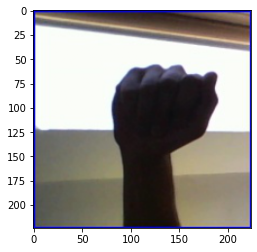

Label =  B


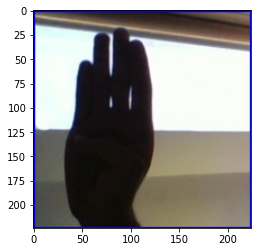

Label =  C


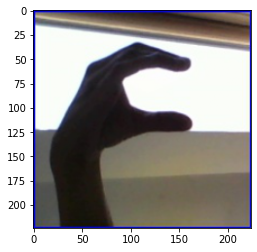

Label =  D


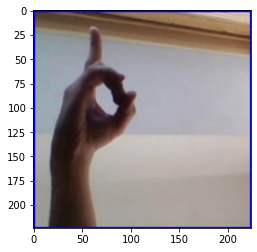

Label =  E


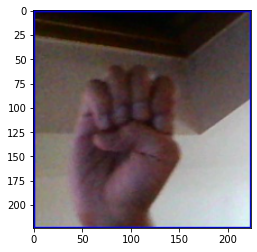

Label =  F


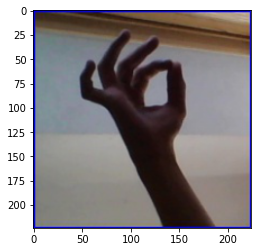

Label =  G


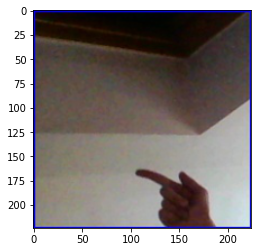

Label =  H


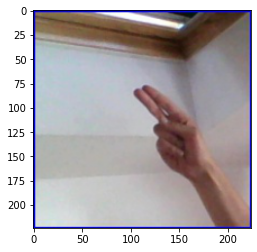

Label =  I


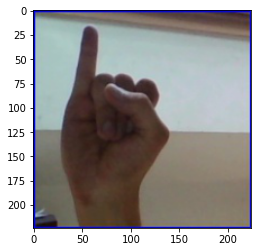

Label =  J


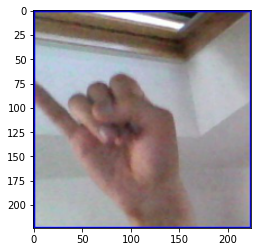

Label =  K


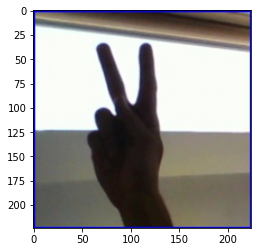

Label =  L


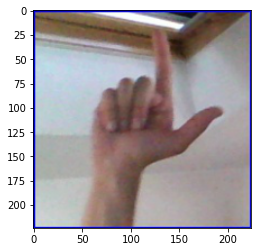

Label =  M


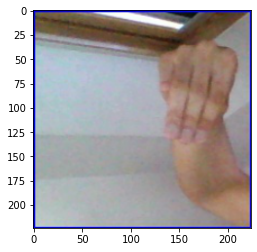

Label =  N


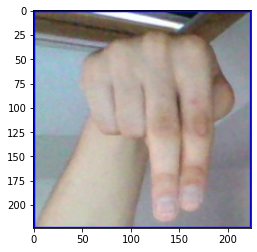

Label =  O


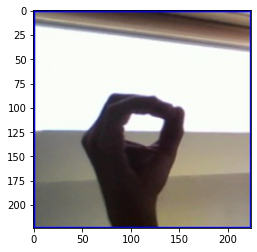

Label =  P


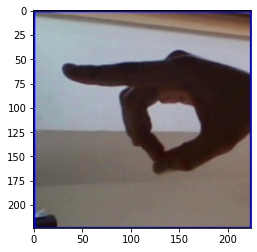

Label =  Q


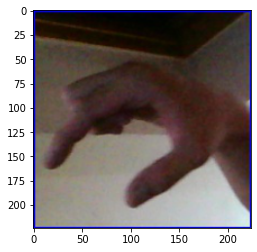

Label =  R


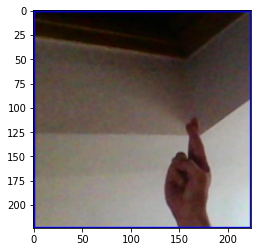

Label =  S


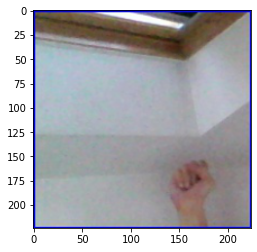

Label =  T


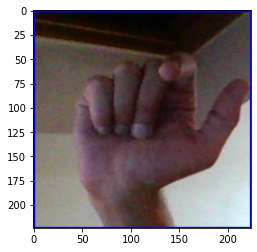

Label =  U


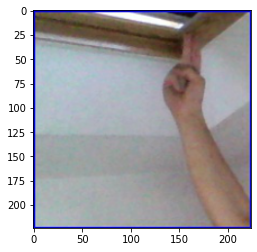

Label =  V


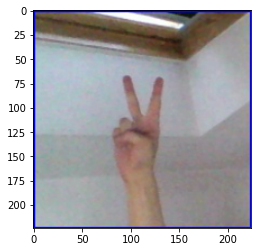

Label =  W


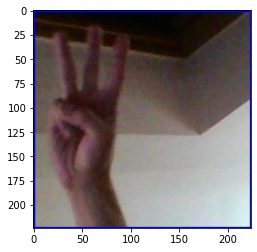

Label =  X


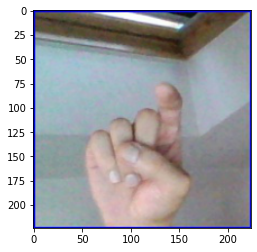

Label =  Y


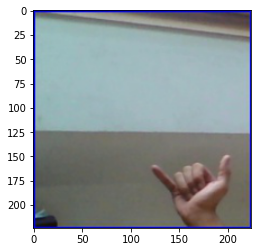

Label =  Z


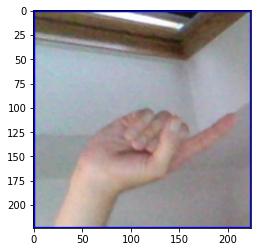

Label =  del


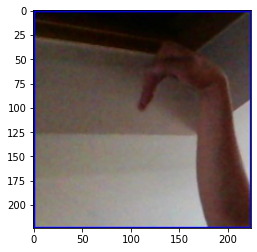

Label =  nothing


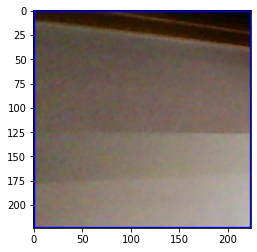

Label =  space


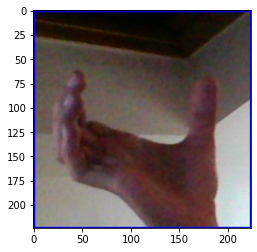

In [19]:
dummy = list(range(len(classes)))

img_samples = {}

for img_batch, label_batch in train_dataloader:
    for i in range(batch_size):
        label = label_batch[i]
        if(label in dummy):
            img = img_batch[i].permute(1,2,0)
            dummy.remove(label)
            img_samples[classes[label]] = img
    if(len(dummy) == 0): 
        break

for label in sorted(img_samples.keys()):
    img = img_samples[label]
    print("Label = ",label)
    plt.imshow(img)
    plt.show()

## ResNet34 - From Scratch

Basic ResNet Block

In [20]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        
        super(BasicBlock,self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        
        identity = x

        # 1st Conv Block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2nd Conv Block
        out = self.conv2(out)
        out = self.bn2(out)

        # Add Skip Layer

        # If identity is not the same shape; downsample it
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add Identity
        out += identity

        # Relu
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super(ResNet,self).__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

ResNet34

In [21]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

Training the Model

In [22]:
model=resnet34()
if torch.cuda.is_available():
    model.cuda()

# Defining which parameters to train
optimizer = define_optimizer(model,learning_rate)

# Calculating the total number of steps
total_step = len(train_dataloader)

for epoch in range(num_epochs):

    # Training
    for i, (images, labels) in enumerate(train_dataloader):  
        
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward Prop
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward Prop and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Freeing the Memory
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/2], Loss: 0.0079
Accuracy of the network on the 5000 validation images: 99.92528735632185 %
Epoch [2/2], Loss: 0.0012
Accuracy of the network on the 5000 validation images: 99.99425287356321 %


Testing

In [23]:
from pathlib import Path
from PIL import Image


test_data_path = Path(path_test)


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

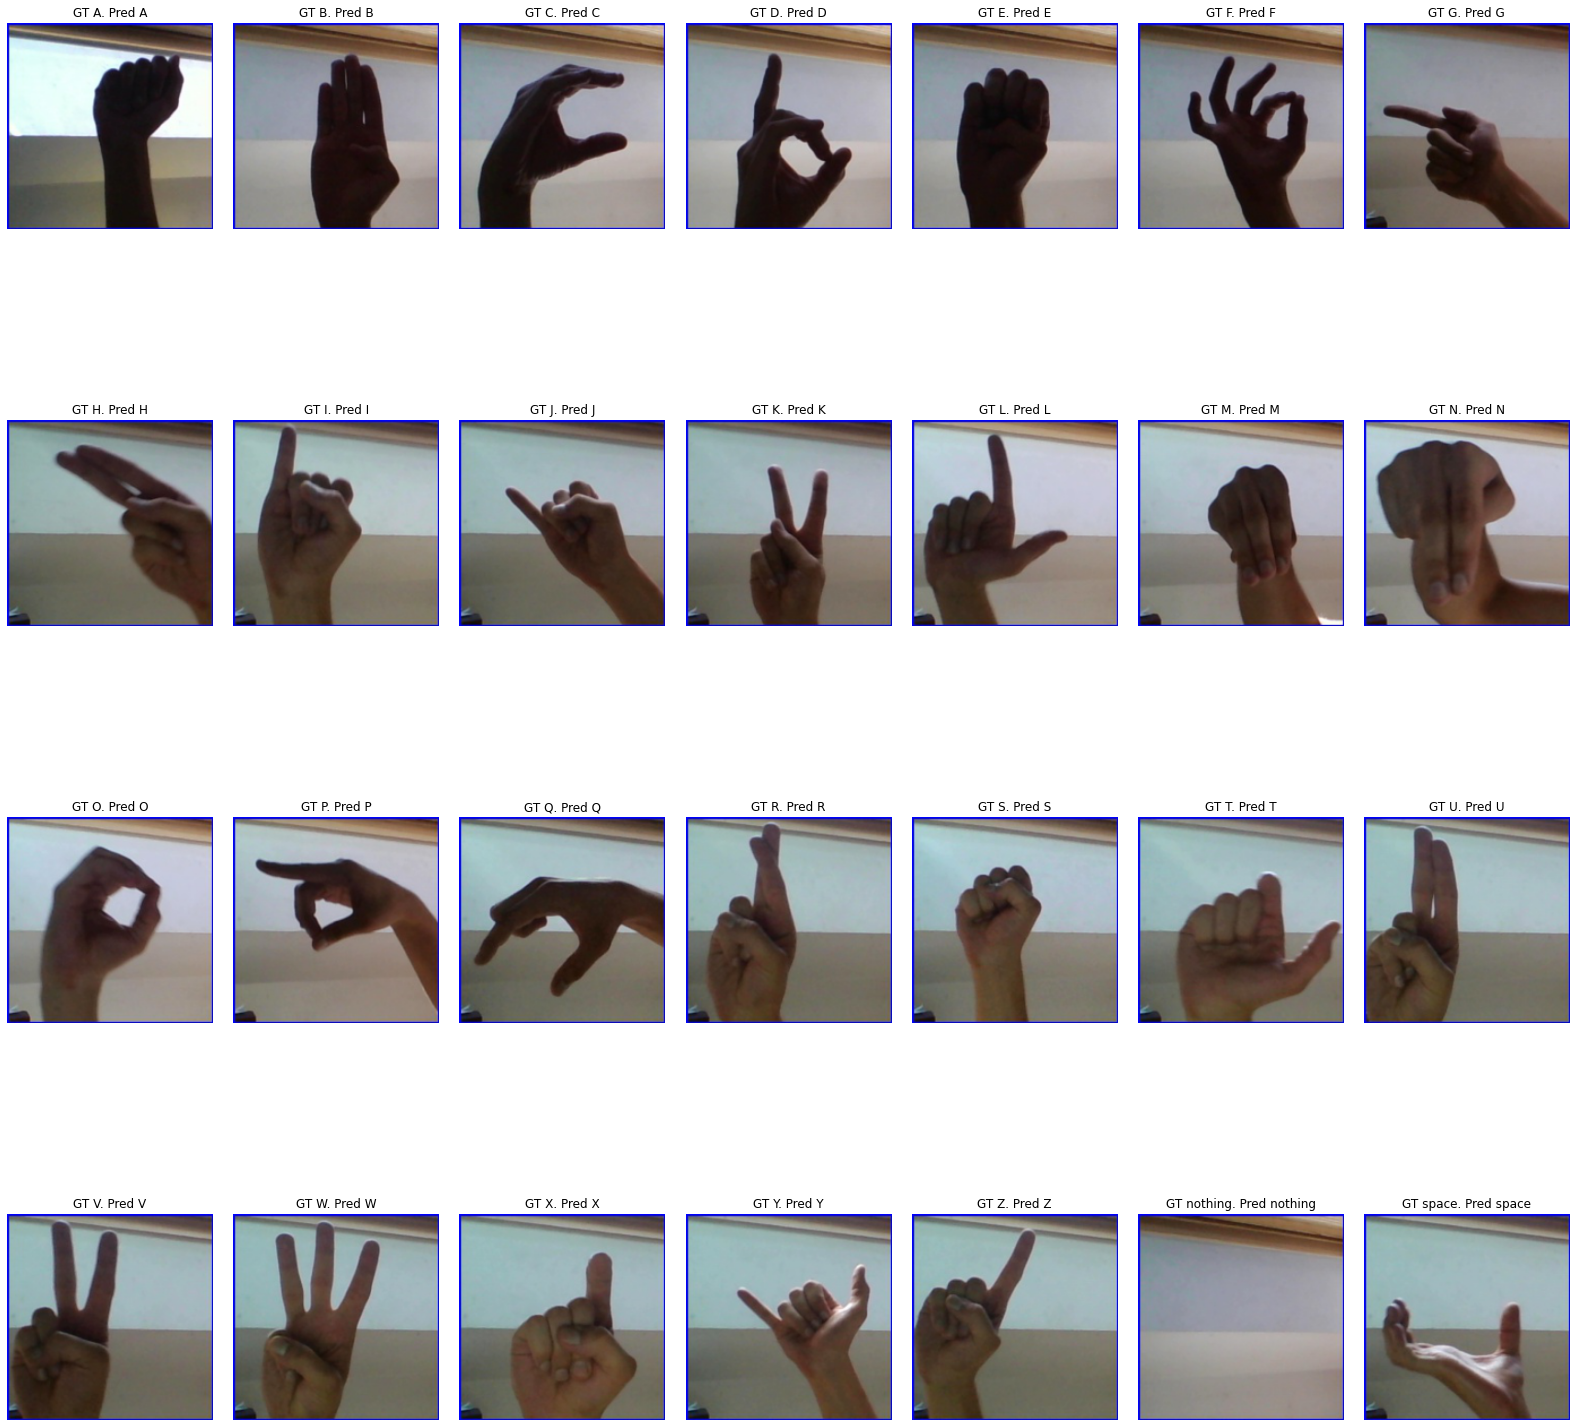

In [25]:
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)

columns = 7
row = round(len(test_dataset) / columns)

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
for img, label in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    model.eval()
    prediction = model(img[None])

    ax[i][j].imshow(img.cpu().permute(1, 2, 0))
    ax[i][j].set_title(f'GT {label}. Pred {classes[torch.max(prediction, dim=1)[1]]}')
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1

plt.show()

## Explanation of every Layer in ResNet34

Input of Batch Size 2, 3 Planes (RGB) each of size 200*200

In [26]:
inp = torch.randn([2,3,200,200])

Conv Block:

Conv2d Layer:
No. of Input Planes = 3; No. of Output Planes = 64; Kernel Size = 7*7; Padding = 3; Stride = 2

Batch Normalization:
Same number of layers; normalize the values ((x-mean)/std)

Activation: Relu

Max Pool: Take the max value in the kernel/filter during convolution

In [27]:
print(inp.shape)
conv_block = nn.Sequential(nn.Conv2d(3,64,kernel_size=7, stride=2, padding=3, bias=False), #100,100
                       nn.BatchNorm2d(64),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) # 50,50
print(conv_block)

out=conv_block(inp)
out.shape

torch.Size([2, 3, 200, 200])
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)


torch.Size([2, 64, 50, 50])

Making the Basic Buiding Block of a ResNet

In [28]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        
        super().__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        
        identity = x

        # 1st Conv Block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2nd Conv Block
        out = self.conv2(out)
        out = self.bn2(out)

        # Add Skip Layer

        # If identity is not the same shape; downsample it
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add Identity
        out += identity

        # Relu
        out = self.relu(out)

        return out

In [29]:
print(BasicBlock(64,128))

t = torch.randn((2,64,50,50))
print(t.shape)

print(BasicBlock(64,64)(t).shape)

BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([2, 64, 50, 50])
torch.Size([2, 64, 50, 50])


Making the Layers (Big Blocks) of ResNet

Double the number of planes in the first block, constant planes in the remaining

In [30]:
def _make_layer(block, inplanes,planes, blocks, stride=1):
    # Define the downsample layer
    downsample = None  
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(            
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )
    
    # Increase the number of layers in the first block
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    # Same number of layers in the remaining blocks
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    
    # Return Sequential of all the blocks
    return nn.Sequential(*layers)

Define the number of blocks in each layer

In [31]:
layers=[3, 4, 6, 3]

Layer 1

In [32]:
layer1 =_make_layer(BasicBlock, inplanes=64,planes=64, blocks=layers[0])
layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

Layer 2

In [33]:
layer2 = _make_layer(BasicBlock, 64, 128, layers[1], stride=2)
layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

Understanding why downsampling is necessary

In [34]:
t = torch.rand((2,64,50,50))
print(t.shape) #batch, RGB channels/filters,width,height

o = nn.Conv2d(64,128,3,2,1)(t)
(o.shape)

torch.Size([2, 64, 50, 50])


torch.Size([2, 128, 25, 25])

In [35]:
o+t  #height and width not matching  56,56 !=28,26

RuntimeError: ignored

In [36]:
t_d =nn.Conv2d(64,128,1,2,0)(t)
t_d.shape

torch.Size([2, 128, 25, 25])

In [37]:
(o+t_d).shape

torch.Size([2, 128, 25, 25])

Final Layer (Classification)

In [38]:
num_classes=len(classes)
nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
              nn.Linear(512 , num_classes))

Sequential(
  (0): AdaptiveAvgPool2d(output_size=(1, 1))
  (1): Linear(in_features=512, out_features=29, bias=True)
)